# Performing Natural Language Inference with the SNLI Dataset

The Stanford Natural Language Inference (SNLI) dataset is a recently released corpus of sentence pairs with labelled inferential relationships. Specifically, the first sentence in each pair can either entail, contradict, or be neutral with respect to the second sentence, and our goal is build models that learn to predict this relationship for novel sentence pairs. 

The dataset consists of a training set of ~550,000 labelled sentence pairs, along with development and test sets that each contain ~10,000 labelled sentence pairs. More information about the dataset can be found [here](http://nlp.stanford.edu/projects/snli/).

In the rest of this notebook, we'll compare a number of methods for learning to predict inferential relations between sentences using this dataset. As a simple baseline, we'll first build distributed bag-of-words representations for each sentence, and then use these sentence representations as input to a multilayer perceptron that predicts a class label. 

## 1. Bag-of-Words with Random Embeddings

First, we'll use sentence representations that are a sum of intially random word embeddings that are learned over the course of training. To start, we'll load the dataset and load a prebuilt vocabulary. Then, we'll extract the labelled sentence pairs for the training and development sets:

In [1]:
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

from pysem.corpora import SNLI
from pysem.utils.ml import MultiLayerPerceptron
from pysem.utils.vsa import normalize
from pysem.utils.experiments import bow_accuracy, rnn_accuracy, dnn_accuracy, plot

snli = SNLI(path='/Users/peterblouw/corpora/snli_1.0/')
snli.load_vocab('snli_words.pickle')

snli.extractor = snli.get_xy_pairs
train_data = [pair for pair in snli.train_data if pair.label != '-']
dev_data = [pair for pair in snli.dev_data if pair.label != '-']

Next, we'll use scikit-learn to make a count vectorizer that converts sentences into binary vectors. The vectors will be used to extract the correct word embeddings from an initially random embedding matrix. 300 dimensional embeddings will be used for consistency with the pretrained embeddings to be used in the next example. 

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

dim = 300
vectorizer = CountVectorizer(binary=True)
vectorizer.fit(snli.vocab)

scale = 1 / np.sqrt(dim)
size = (dim, len(vectorizer.get_feature_names()))
bow_embedding_matrix = np.random.normal(loc=0, scale=scale, size=size)

It's now possible to learn a set of embeddings and classifier parameters that will predict inferential relationships for sentences outside of the training set. We'll do minibatch stochastic gradient descent using randomly selected minibatches of 100 pairs from the training data, and we'll do this until we've performed approximately 20 epochs of training over the entire training set.

In [3]:
bow_classifier = MultiLayerPerceptron(di=dim*2, dh=dim, do=3)

minibatch_size = 100
iters = 100000 # approximately equivalent to 20 epochs given minibatch size
rate = 0.1
schedule = 15000 # anneal learning rate approximately every 3 epochs
acc_interval = 1000
acc = [bow_accuracy(dev_data, bow_classifier, bow_embedding_matrix, vectorizer)]

for _ in range(iters):
    minibatch = random.sample(train_data, minibatch_size)

    if _ % schedule == 0 and _ != 0:
        rate = rate / 2
        print('Dropped rate to ', rate)   
    
    if _ % acc_interval == 0 and _ != 0:
        acc.append(bow_accuracy(dev_data, bow_classifier, bow_embedding_matrix, vectorizer))
        
    s1s = [sample.sentence1 for sample in minibatch]
    s2s = [sample.sentence2 for sample in minibatch]
    
    s1_indicators = vectorizer.transform(s1s).toarray().T
    s2_indicators = vectorizer.transform(s2s).toarray().T
    
    s1_embeddings = np.dot(bow_embedding_matrix, s1_indicators)
    s2_embeddings = np.dot(bow_embedding_matrix, s2_indicators)

    # concatenate the sentence representations for input to classifier
    xs = np.vstack((s1_embeddings, s2_embeddings))
    ys = snli.binarize([sample.label for sample in minibatch])

    # update the classifier parameters
    bow_classifier.train(xs, ys, rate=rate)
    
    # update the embedding matrix
    s1s_grad = np.dot(bow_classifier.yi_grad[:dim], s1_indicators.T) 
    s2s_grad = np.dot(bow_classifier.yi_grad[dim:], s2_indicators.T)
    embedding_grad = (s1s_grad + s2s_grad) / minibatch_size
    bow_embedding_matrix -= rate * embedding_grad

Dropped rate to  0.05
Dropped rate to  0.025
Dropped rate to  0.0125
Dropped rate to  0.00625
Dropped rate to  0.003125
Dropped rate to  0.0015625


After training, the accuracy on the training set and the development set can be computed as follows:

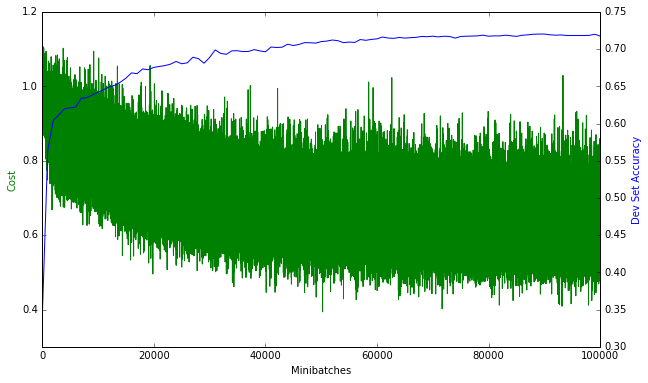

In [4]:
acc.append(bow_accuracy(dev_data, bow_classifier, bow_embedding_matrix, vectorizer))
plot(bow_classifier, acc, acc_interval)

In [53]:
snli.reset_streams()
snli.extractor = snli.get_xy_pairs
test_data = [pair for pair in snli.test_data if pair.label != '-']

print('Train Accuracy: ', bow_accuracy(train_data, bow_classifier, bow_embedding_matrix, vectorizer))
print('Dev Accuracy: ', bow_accuracy(dev_data, bow_classifier, bow_embedding_matrix, vectorizer))
print('Test Accuracy: ', bow_accuracy(test_data, bow_classifier, bow_embedding_matrix, vectorizer))

Train Accuracy:  0.732262767876
Dev Accuracy:  0.717638691323
Test Accuracy:  0.718851791531


## 2. Bag-of-Words with Word2Vec Embeddings

Because the initially random embeddings used in the previous example are tuned to perform optimally on the training data, they are unlikely to aid in generalizing on the basis of similarities in word meaning. For example, if the model learns that sentence "There are dogs outside" entails the sentence "There are animals outside", it would helpful for it be able to predict that the sentence "There are wolves outside" also entails "There are animals outside", due to the similar meanings of the words "dogs" and "wolves". It is possible to take advantage of these kinds of similarities in word meaning by initializing the word embeddings using a embedding vectors produced using methods such as those used in Word2Vec. The embeddings can be fine tuned over the course of learning, and after training is complete, we can get a measure of the improvement on the task that results from encoding prior knowledge about similarity relations between words into the model. Note that not every word in the SNLI vocab corresponds to a pretrained Word2Vec embedding. In cases where a SNLI word is outside of the Word2Vec vocabulary, we'll intialize it's embedding as a random unit vector as before. 

In [7]:
vocab = vectorizer.get_feature_names()
idx_lookup = {word: idx for idx, word in enumerate(vocab)}
w2v_embedding_matrix = np.zeros((dim, len(vocab)))

with open('pretrained_snli_embeddings.pickle', 'rb') as pfile:
    word2vec = pickle.load(pfile)

for word in vocab:
    idx = idx_lookup[word]
    try:
        embedding = word2vec[word]
    except KeyError:
        scale = 1 / np.sqrt(dim)
        embedding = normalize(np.random.normal(loc=0, scale=scale, size=dim))
    
    w2v_embedding_matrix[:, idx] = embedding

Now that the embedding matrix has been initialized, we can use the same training method as before to learn model for predicting labels over the dataset.

In [8]:
w2v_classifier = MultiLayerPerceptron(di=dim*2, dh=dim, do=3)

rate = 0.1
acc = [bow_accuracy(dev_data, w2v_classifier, w2v_embedding_matrix, vectorizer)]

for _ in range(iters):
    minibatch = random.sample(train_data, minibatch_size)

    if _ % schedule == 0 and _ != 0:
        rate = rate / 2
        print('Dropped rate to ', rate)   

    if _ % acc_interval == 0 and _ != 0:
        acc.append(bow_accuracy(dev_data, w2v_classifier, w2v_embedding_matrix, vectorizer))

    s1s = [sample.sentence1 for sample in minibatch]
    s2s = [sample.sentence2 for sample in minibatch]
    
    s1_indicators = vectorizer.transform(s1s).toarray().T
    s2_indicators = vectorizer.transform(s2s).toarray().T
    
    s1_embeddings = np.dot(w2v_embedding_matrix, s1_indicators)
    s2_embeddings = np.dot(w2v_embedding_matrix, s2_indicators)

    # concatenate the sentence representations for input to classifier
    xs = np.vstack((s1_embeddings, s2_embeddings))
    ys = snli.binarize([sample.label for sample in minibatch])

    # update the classifier parameters
    w2v_classifier.train(xs, ys, rate=rate)

    # update the embedding matrix
    s1s_grad = np.dot(w2v_classifier.yi_grad[:dim], s1_indicators.T) 
    s2s_grad = np.dot(w2v_classifier.yi_grad[dim:], s2_indicators.T)
    embedding_grad = (s1s_grad + s2s_grad) / minibatch_size
    w2v_embedding_matrix -= rate * embedding_grad

Dropped rate to  0.05
Dropped rate to  0.025
Dropped rate to  0.0125
Dropped rate to  0.00625
Dropped rate to  0.003125
Dropped rate to  0.0015625


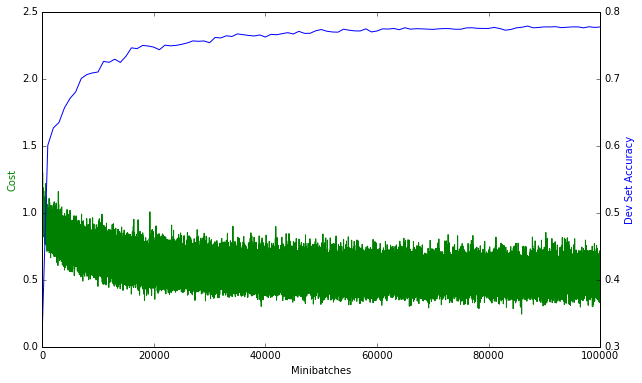

In [9]:
acc.append(bow_accuracy(dev_data, w2v_classifier, w2v_embedding_matrix, vectorizer))
plot(w2v_classifier, acc, acc_interval)

In [18]:
print('Train Accuracy: ', bow_accuracy(train_data, w2v_classifier, w2v_embedding_matrix, vectorizer))
print('Dev Accuract: ', bow_accuracy(dev_data, w2v_classifier, w2v_embedding_matrix, vectorizer))
print('Test Accuracy: ', bow_accuracy(test_data, w2v_classifier, w2v_embedding_matrix, vectorizer))

Train Accuracy:  0.792583100186
Dev Accuract:  0.777687461898
Test Accuracy:  0.769136807818


# 3. Sentence Encoding with a Recurrent Neural Network

A well-known drawback of bag-of-words models is that they completely ignore word order. To correct for this shortcoming, it is helpful to produce distributed representations of sentences using a sequential model, such as an RNN. In the context of SNLI, an RNN will build up an order-sensitive representation of a sentence by recursively composing a distributed representation of the current word in the sentence with a distribution representation that models all of the previous words in the sentence. As before, the resulting representations of each sentence in a given pair will be concatenated and passed through an MLP to predict as class label.    

In [22]:
from pysem.networks import RecurrentNetwork

dim = 400
rate = 0.01

s1_rnn = RecurrentNetwork(dim=dim, vocab=snli.vocab)
s2_rnn = RecurrentNetwork(dim=dim, vocab=snli.vocab)

rnn_classifier = MultiLayerPerceptron(di=2*dim, dh=dim, do=3)

In [23]:
acc = [rnn_accuracy(dev_data, rnn_classifier, s1_rnn, s2_rnn)]

for _ in range(iters):
    minibatch = random.sample(train_data, minibatch_size)
    s1s = [sample.sentence1 for sample in minibatch]
    s2s = [sample.sentence2 for sample in minibatch]

    if _ % schedule == 0 and _ != 0:
        rate = rate / 2
        print('Dropped rate to ', rate)   
        
    if _ % acc_interval == 0 and _ != 0:
        acc.append(rnn_accuracy(dev_data, rnn_classifier, s1_rnn, s2_rnn))

    s1_rnn.forward_pass(s1s)
    s2_rnn.forward_pass(s2s)

    s1 = s1_rnn.get_root_embedding()
    s2 = s2_rnn.get_root_embedding()

    xs = np.concatenate((s1, s2))
    ys = SNLI.binarize([sample.label for sample in minibatch])

    rnn_classifier.train(xs, ys, rate=rate)

    emb1_grad = rnn_classifier.yi_grad[:dim]
    emb2_grad = rnn_classifier.yi_grad[dim:]

    s1_rnn.backward_pass(emb1_grad, rate=rate)
    s2_rnn.backward_pass(emb2_grad, rate=rate)

Dropped rate to  0.005
Dropped rate to  0.0025
Dropped rate to  0.00125
Dropped rate to  0.000625
Dropped rate to  0.0003125
Dropped rate to  0.00015625


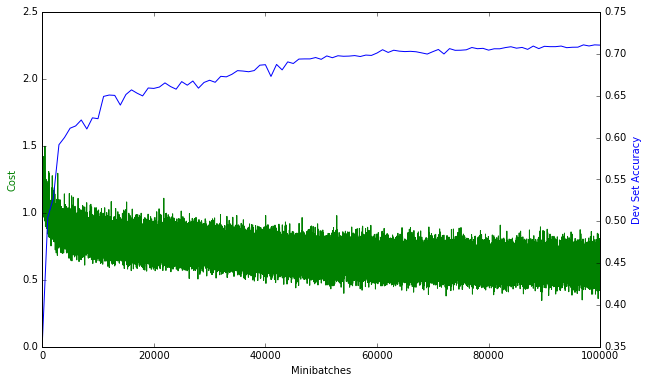

In [24]:
acc.append(rnn_accuracy(dev_data, rnn_classifier, s1_rnn, s2_rnn))
plot(rnn_classifier, acc, acc_interval)

In [26]:
print('Train Accuracy: ', rnn_accuracy(train_data, rnn_classifier, s1_rnn, s2_rnn))
print('Dev Accuracy: ', rnn_accuracy(dev_data, rnn_classifier, s1_rnn, s2_rnn))
print('Test Accuracy: ', rnn_accuracy(test_data, rnn_classifier, s1_rnn, s2_rnn))

Train Accuracy:  0.748071871809
Dev Accuracy:  0.710424710425
Test Accuracy:  0.710504885993


# 4. Sentence Encoding with a Tree-Structured Neural Network

Plain neural networks are commonly thought to be difficult to train, largely because they have trouble learning long-range dependencies between items that far apart in an input sequence. The trouble arises for two reasons: first, most of the knowledge the model acquires about these dependencies needs to be stored in the single weight matrix that defines the recurrence applied by the model - this is tough if there is a lot of subtle variability in the input sequences or the weight matrix is relatively small; second, parameter learning is difficult due to the fact that gradients tend to either grow or shrink exponentially as they propogated backwards through the unfolded network - learning is highly unstable in the case of exploding gradients, and essentially non-existent in the case of vanishing gradients. There are common tricks for getting around these problems (e.g. clever weight initializations, use of LSTM networks, etc.), but one alternative that is less commonly adopted involves restructuring the recurrence that defines the model to be more suited to the task being performed. This is precisely what is done by use a Tree-Structured neural network, which unfolds in shape of a parse tree rather the chain-like sequence that is characteristic of a plain RNN. 

In [36]:
from pysem.networks import DependencyNetwork

dim = 300
rate = 0.0001

pretrained = 'pretrained_snli_embeddings.pickle'
s1_dnn = DependencyNetwork(dim=dim, vocab=snli.vocab, pretrained=pretrained)
s2_dnn = DependencyNetwork(dim=dim, vocab=snli.vocab, pretrained=pretrained)

dnn_classifier = MultiLayerPerceptron(di=2*dim, dh=dim, do=3)

acc = [dnn_accuracy(dev_data, dnn_classifier, s1_dnn, s2_dnn)]

In [37]:
for _ in range(iters):
    batch = random.sample(train_data, minibatch_size)

    if _ % schedule == 0 and _ != 0:
        rate = rate / 2
        print('Dropped rate to ', rate)

    if _ % acc_interval == 0 and _ != 0:
        acc.append(dnn_accuracy(dev_data, dnn_classifier, s1_dnn, s2_dnn))

    for sample in batch:
        s1_dnn.forward_pass(sample.sentence1)
        s2_dnn.forward_pass(sample.sentence2)

        emb1 = s1_dnn.get_root_embedding()
        emb2 = s2_dnn.get_root_embedding()

        xs = np.concatenate((emb1, emb2))
        ys = [sample.label]

        dnn_classifier.train(xs, snli.binarize(ys), rate=rate)

        emb1_grad = dnn_classifier.yi_grad[:dim] * s1_dnn.tanh_grad(emb1)
        emb2_grad = dnn_classifier.yi_grad[dim:] * s2_dnn.tanh_grad(emb2)

        s1_dnn.backward_pass(emb1_grad, rate=rate)
        s2_dnn.backward_pass(emb2_grad, rate=rate)

Dropped rate to  0.00025
Dropped rate to  0.000125
Dropped rate to  6.25e-05
Dropped rate to  3.125e-05
Dropped rate to  1.5625e-05
Dropped rate to  7.8125e-06


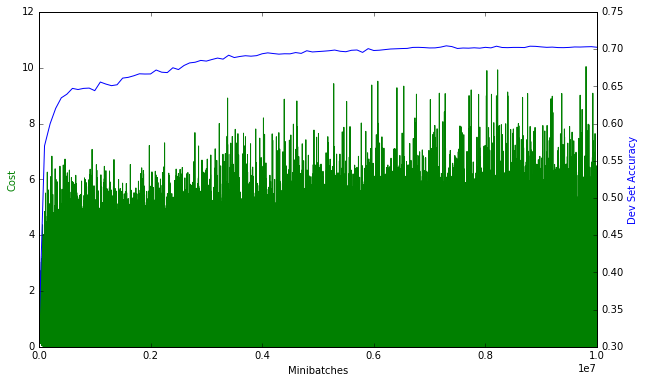

In [38]:
acc.append(dnn_accuracy(dev_data, dnn_classifier, s1_dnn, s2_dnn))
plot(dnn_classifier, acc, acc_interval, scale=minibatch_size)

In [39]:
print('Train Accuracy: ', dnn_accuracy(train_data, dnn_classifier, s1_dnn, s2_dnn))
print('Dev Accuracy: ', dnn_accuracy(dev_data, dnn_classifier, s1_dnn, s2_dnn))
print('Test Accuracy: ', dnn_accuracy(test_data, dnn_classifier, s1_dnn, s2_dnn))

Train Accuracy:  0.7239095176812587
Dev Accuracy:  0.7026010973379394
Test Accuracy:  0.7070439739413681


Note that the plotted costs are no longer averaged over a minibatch of size 100, which makes it difficult to see any trends or changes over the course of learning. 

# 5. Sentence Encoding with Tree-Structured HRR Networks

One disadvantage of all of the structured models we've looked at so far is that none of them produce hidden states that are directly interpretable - the states are simply continuous vectors that can be usefully classifed by an MLP to predict inferential relationships between sentences. However, if we adjust the dependency network so that the weight matrices associated with each syntactic dependency apply a fixed circular convolution to the hidden state of their dependents, we can structure the network to produce sentence representations that are directly interpretable as HRRs. This "Holographic Network" is actually quite a bit simpler than the models already considered, because there are no non-linearities, and no learned weight matrices. In fact, the only free parameters are the HRRs corresponding to each word in the model's vocabulary. Given the lower number of free parameters, competitive performance in the SNLI task is unlikely, as the following simulations illustrate.

In [54]:
from pysem.networks import HolographicNetwork

rate = 0.0001
iters = 30000

s1_dnn = HolographicNetwork(dim=dim, vocab=snli.vocab)
s2_dnn = HolographicNetwork(dim=dim, vocab=snli.vocab)
dnn_classifier = MultiLayerPerceptron(di=2*dim, dh=dim, do=3)

acc = [dnn_accuracy(dev_data, dnn_classifier, s1_dnn, s2_dnn)]

In [55]:
for _ in range(iters):
    batch = random.sample(train_data, minibatch_size)

    if _ % schedule == 0 and _ != 0:
        rate = rate / 2
        print('Dropped rate to ', rate)

    if _ % acc_interval == 0 and _ != 0:
        acc.append(dnn_accuracy(dev_data, dnn_classifier, s1_dnn, s2_dnn))

    for sample in batch:
        s1_dnn.forward_pass(sample.sentence1)
        s2_dnn.forward_pass(sample.sentence2)

        emb1 = s1_dnn.get_root_embedding()
        emb2 = s2_dnn.get_root_embedding()

        xs = np.concatenate((emb1, emb2))
        ys = [sample.label]

        dnn_classifier.train(xs, snli.binarize(ys), rate=rate)

        emb1_grad = dnn_classifier.yi_grad[:dim] * s1_dnn.tanh_grad(emb1)
        emb2_grad = dnn_classifier.yi_grad[dim:] * s2_dnn.tanh_grad(emb2)

        s1_dnn.backward_pass(emb1_grad, rate=rate)
        s2_dnn.backward_pass(emb2_grad, rate=rate)

Dropped rate to  5e-05


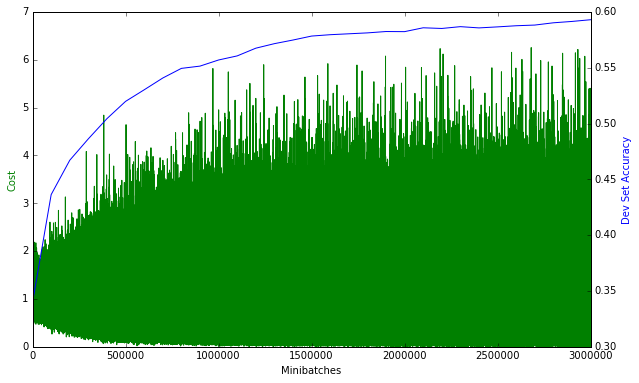

In [56]:
acc.append(dnn_accuracy(dev_data, dnn_classifier, s1_dnn, s2_dnn))
plot(dnn_classifier, acc, acc_interval, scale=minibatch_size)

In [57]:
print('Train Accuracy: ', dnn_accuracy(train_data, dnn_classifier, s1_dnn, s2_dnn))
print('Dev Accuracy: ', dnn_accuracy(dev_data, dnn_classifier, s1_dnn, s2_dnn))
print('Test Accuracy: ', dnn_accuracy(test_data, dnn_classifier, s1_dnn, s2_dnn))

Train Accuracy:  0.5923053259478637
Dev Accuracy:  0.5930705141231457
Test Accuracy:  0.5855048859934854
